In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!pip install 'shimmy>=0.2.1'
!pip install git+https://github.com/DLR-RM/stable-baselines3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from tqdm.notebook import tqdm
import torch
from gym.utils import seeding
import gym
from gym import spaces
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import DDPG
import ast
import warnings
warnings.simplefilter("ignore")

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 67.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/DLR-RM/stable-baselines3 to /tmp/pip-req-build-vk0ao0cx
  Running command git clone --filter=blob:none --quiet https://github.com/DLR-RM/stable-baselines3 /tmp/pip-req-build-vk0ao0cx
  Resolved https://github.com/DLR-RM/stable-baselines3 to commit fd0cd82339511b54cd3907df228a656f2a32f0b8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for stable-baselines3: filename=stable_baselines3-2.0.0a8-py3-none-any.whl size=177948 sha256=ff8cc8bfd95b479c010f5f32b7f880aacb9cf5743f095326c0be33c030460eac
  Stored in directory: /tmp/pip-ephem-wheel-cache-numddv31/wheels/3

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [ ]:
def set_random_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed) # Numpy module.
  random.seed(seed) # Python random module.
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True
# set random seed
seed = 0
set_random_seed(seed=seed)

In [ ]:
ROOT_PATH = '/content/drive/MyDrive/How To Get Rich Quick (with RL)'
directory = ROOT_PATH + '/data/'

# set global variable TOKENS used in all environments
TOKENS = ['ADA', 'ATOM', 'AVAX', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LINK', 'LTC', 'MATIC', 'SHIB', 'SOL', 'TRX', 'UNI', 'XRP']

df_close = pd.read_csv(directory + 'df_close.csv')
df_close.open_time_ms = pd.to_datetime(df_close['open_time_ms'])
df_close.head(20)

,open_time_ms,ADA_close,ATOM_close,AVAX_close,BNB_close,BTC_close,DOGE_close,DOT_close,ETH_close,LINK_close,LTC_close,MATIC_close,SHIB_close,SOL_close,TRX_close,UNI_close,XRP_close,USD_close
0,2022-01-01 00:00:00,1.314,32.81,109.98,512.9,46321.34,0.1705,26.75,3690.09,19.57,146.4,2.541,0.000033,170.40,0.07552,17.08,0.8334,1.0
1,2022-01-01 00:05:00,1.316,32.58,110.06,513.3,46371.11,0.1703,26.80,3696.55,19.58,146.6,2.545,0.000033,170.60,0.07538,17.09,0.8330,1.0
2,2022-01-01 00:10:00,1.317,32.46,110.07,513.5,46332.51,0.1705,26.84,3691.90,19.60,146.7,2.546,0.000033,170.85,0.07538,17.11,0.8322,1.0
3,2022-01-01 00:15:00,1.317,32.47,109.95,513.5,46293.90,0.1703,26.77,3689.51,19.57,146.6,2.536,0.000033,171.07,0.07531,17.08,0.8319,1.0
4,2022-01-01 00:20:00,1.322,32.77,110.61,514.3,46395.53,0.1709,26.95,3699.45,19.64,147.0,2.548,0.000034,171.20,0.07553,17.10,0.8349,1.0
5,2022-01-01 00:25:00,1.320,32.92,110.66,514.2,46375.42,0.1709,26.97,3697.71,19.65,147.0,2.546,0.000034,171.14,0.07549,17.04,0.8336,1.0
6,2022-01-01 00:30:00,1.322,32.94,110.66,514.5,46443.65,0.1712,27.00,3700.98,19.67,147.1,2.549,0.000034,171.46,0.07554,17.04,0.8343,1.0
7,2022-01-01 00:35:00,1.325,33.05,111.27,515.2,46530.70,0.1715,27.08,3708.69,19.77,147.5,2.558,0.000034,171.64,0.07559,17.13,0.8371,1.0
8,2022-01-01 00:40:00,1.326,33.16,111.11,515.9,46610.81,0.1717,27.12,3714.52,19.82,147.5,2.561,0.000034,171.75,0.07571,17.18,0.8374,1.0
9,2022-01-01 00:45:00,1.329,33.44,111.74,517.2,46693.74,0.1721,27.24,3722.93,19.90,148.1,2.575,0.000034,172.28,0.07587,17.21,0.8390,1.0


In [ ]:
df_volume = pd.read_csv(directory+'df_volume.csv')
df_volume.open_time_ms = pd.to_datetime(df_volume['open_time_ms'])
df_volume.head()

,open_time_ms,ADA_volume,ATOM_volume,AVAX_volume,BNB_volume,BTC_volume,DOGE_volume,DOT_volume,ETH_volume,LINK_volume,LTC_volume,MATIC_volume,SHIB_volume,SOL_volume,TRX_volume,UNI_volume,XRP_volume,USD_volume
0,2022-01-01 00:00:00,1209224.3,54621.76,8587.78,2352.644,185.67558,2519628.0,24592.11,1363.4570,33197.32,2050.067,449849.2,2.162479e+10,4329.30,3076457.5,6739.54,945000.0,0.0
1,2022-01-01 00:05:00,298386.5,28489.13,7392.95,1688.173,123.43577,1783685.0,17049.93,862.5494,13470.81,655.730,203782.8,1.347277e+10,2212.70,2180233.5,4115.82,468801.0,0.0
2,2022-01-01 00:10:00,389329.2,20890.84,5129.06,1023.833,77.54574,1428416.0,12995.91,753.5524,10046.50,544.532,181298.2,1.042813e+10,3310.82,1649554.4,7447.60,631674.0,0.0
3,2022-01-01 00:15:00,221077.2,9810.92,7974.74,1377.344,101.14315,1148033.0,9857.93,438.4134,7221.73,416.076,141379.4,2.456715e+10,2917.19,1038627.4,10391.02,346621.0,0.0
4,2022-01-01 00:20:00,189448.2,7518.41,4352.98,1304.058,135.32479,894261.0,33604.41,372.5966,6060.02,971.667,153877.3,6.909299e+09,2954.40,909110.0,4209.92,546138.0,0.0




---

### Technical Indicator 1 : Exponential Moving Average (EMA)

In [ ]:
def calculate_ema_np(data, period):
    cryptocurrencies = ['ADA_close', 
                        'ATOM_close', 
                        'AVAX_close', 
                        'BNB_close', 
                        'BTC_close', 
                        'DOGE_close', 
                        'DOT_close', 
                        'ETH_close', 
                        'LINK_close', 
                        'LTC_close', 
                        'MATIC_close', 
                        'SHIB_close', 
                        'SOL_close', 
                        'TRX_close', 
                        'UNI_close', 
                        'XRP_close',
                        'USD_close']

    close_prices = data[cryptocurrencies].to_numpy()
    
    # Calculate the initial Simple Moving Average (SMA) for each cryptocurrency
    sma = np.mean(close_prices[:period - 1], axis=0)

    # Initialize the EMA array
    ema_data = np.zeros((len(close_prices), close_prices.shape[1]))
    ema_data[period - 2] = sma

    # Calculate EMA for each cryptocurrency using the provided formula
    alpha = 2 / (period + 1)
    for i in range(period - 1, len(close_prices)):
        ema_data[i] = (close_prices[i] * alpha) + (ema_data[i - 1] * (1 - alpha))

    return pd.DataFrame(ema_data, columns=cryptocurrencies)

# Calculate EMA for the given period
period = 13
ema_data = calculate_ema_np(df_close, period)
ema_data = ema_data[period-1:].reset_index(drop=True)
ema_data = ema_data.rolling(window=2).mean().iloc[1:].reset_index(drop=True)

pd.DataFrame(ema_data)

,ADA_close,ATOM_close,AVAX_close,BNB_close,BTC_close,DOGE_close,DOT_close,ETH_close,LINK_close,LTC_close,MATIC_close,SHIB_close,SOL_close,TRX_close,UNI_close,XRP_close,USD_close
0,1.323418,33.067092,110.866224,515.311224,46502.541071,0.171249,27.028112,3707.319235,19.775918,147.611735,2.557536,0.000034,171.576735,0.075617,17.128878,0.835130,1.0
1,1.324216,33.163936,110.936764,515.702478,46533.748776,0.171349,27.059096,3709.760058,19.817930,147.795773,2.560173,0.000034,171.744344,0.075652,17.144752,0.835783,1.0
2,1.325542,33.258374,110.989369,516.180696,46574.913236,0.171506,27.101368,3713.469336,19.863226,148.017805,2.564149,0.000034,171.948009,0.075706,17.171216,0.837456,1.0
3,1.326822,33.327892,110.994459,516.612025,46615.842774,0.171670,27.139744,3717.476573,19.903479,148.200976,2.568485,0.000034,172.191865,0.075751,17.196042,0.838963,1.0
4,1.327704,33.376050,110.974536,516.953164,46646.533806,0.171788,27.169781,3720.477063,19.938696,148.322265,2.572130,0.000034,172.419456,0.075784,17.215894,0.839804,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127982,0.337070,11.490103,16.778852,332.531289,27862.965499,0.071520,6.092839,1745.347927,6.965168,79.690629,1.104081,0.000010,22.002457,0.065720,6.163084,0.387049,1.0
127983,0.337432,11.505017,16.804016,332.762534,27893.938999,0.071601,6.101362,1747.276080,6.975430,79.830539,1.106519,0.000010,22.049249,0.065747,6.168786,0.387235,1.0
127984,0.337777,11.520800,16.826299,332.982172,27919.486285,0.071682,6.110096,1749.175926,6.985083,79.960462,1.109309,0.000010,22.092928,0.065770,6.174888,0.387416,1.0
127985,0.337973,11.533258,16.843971,333.156147,27937.723244,0.071736,6.116725,1750.471508,6.993714,80.044682,1.111251,0.000011,22.125367,0.065786,6.179619,0.387506,1.0


In [ ]:
# Calculate EMA for the given period
period = 13
ema_data = calculate_ema_np(df_close, period)
ema_data = ema_data[period-1:].reset_index(drop=True)
ema_data = ema_data.rolling(window=2).mean().iloc[1:].reset_index(drop=True)



---

### Technical Indicator 2 : Subsequent % Change in Closing Prices

In [ ]:
# calculate percentage change between subsequent rows (every 5 mins)
rets = df_close.iloc[:, 1:].pct_change()

# first row is NaN. So take [1:, :]
rets = torch.tensor(rets.iloc[1:, :].values)

pd.DataFrame(rets)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.001522,-0.007010,0.000727,0.000780,0.001074,-0.001173,0.001869,0.001751,0.000511,0.001366,0.001574,0.001196,0.001174,-0.001854,0.000585,-0.000480,0.0
1,0.000760,-0.003683,0.000091,0.000390,-0.000832,0.001174,0.001493,-0.001258,0.001021,0.000682,0.000393,-0.000299,0.001465,0.000000,0.001170,-0.000960,0.0
2,0.000000,0.000308,-0.001090,0.000000,-0.000833,-0.001173,-0.002608,-0.000647,-0.001531,-0.000682,-0.003928,-0.001792,0.001288,-0.000929,-0.001753,-0.000360,0.0
3,0.003797,0.009239,0.006003,0.001558,0.002195,0.003523,0.006724,0.002694,0.003577,0.002729,0.004732,0.002394,0.000760,0.002921,0.001171,0.003606,0.0
4,-0.001513,0.004577,0.000452,-0.000194,-0.000433,0.000000,0.000742,-0.000470,0.000509,0.000000,-0.000785,0.000000,-0.000350,-0.000530,-0.003509,-0.001557,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127994,0.001773,0.002600,0.002367,0.002402,0.001844,0.002089,0.002122,0.001878,0.002996,0.000497,0.002159,0.002852,0.002701,0.001368,0.001942,0.002063,0.0
127995,0.003540,0.004235,0.001771,0.001497,0.001514,0.004170,0.004725,0.004096,0.001991,0.003726,0.012656,0.001896,0.005388,0.000911,0.003553,-0.000772,0.0
127996,-0.002058,-0.000602,-0.001179,-0.000598,-0.002011,-0.002076,-0.001459,-0.002116,-0.000284,-0.001980,-0.003811,0.000000,-0.003126,-0.000910,-0.000805,0.001546,0.0
127997,-0.002062,-0.000689,0.000000,0.000000,0.000187,-0.000832,-0.000487,-0.000529,0.000994,-0.002727,-0.001780,-0.000946,0.000000,0.000000,-0.000322,-0.003858,0.0




---

### Combine TI2 with Closing Prices at timestep $t$ into 3D Tensor

In [ ]:
# Take row index 13 onwards and all cryptos (index 0 = opening time)
px = torch.tensor(df_close.iloc[13:, 1:].values)

# Dim 0 = total timesteps, Dim 1 = # cryptos, Dim 2 = Lookback period + 1
data = torch.zeros(size=[128000-13, 17, 13])

# Set the front slice of the 3D tensor to the current closing price
data[:,:,0] = px

# Fill in the back slices of the 3D tensor to the percentage change on returns
for i in range(data.shape[0]):
    data[i,:,1:] = rets[i:i+12,:].T

In [ ]:
pd.DataFrame(px)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1.3270,33.670,111.30,517.5,46675.00,0.17170,27.180,3721.21,20.020,148.60,2.5710,0.000034,172.63,0.07574,17.170,0.8344,1.0
1,1.3310,33.820,111.42,518.6,46766.99,0.17220,27.310,3727.60,20.120,149.20,2.5810,0.000034,172.87,0.07598,17.310,0.8450,1.0
2,1.3360,33.830,111.19,519.5,46876.81,0.17270,27.400,3743.85,20.150,149.50,2.5950,0.000034,173.47,0.07608,17.350,0.8500,1.0
3,1.3330,33.660,110.86,518.9,46846.03,0.17260,27.340,3739.19,20.140,149.10,2.5940,0.000034,173.84,0.07596,17.340,0.8460,1.0
4,1.3330,33.670,110.85,519.1,46815.33,0.17240,27.360,3737.77,20.160,149.00,2.5940,0.000034,173.73,0.07600,17.330,0.8437,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127982,0.3390,11.570,16.94,333.9,28058.54,0.07194,6.138,1755.25,7.030,80.52,1.1141,0.000011,22.27,0.06588,6.192,0.3885,1.0
127983,0.3402,11.619,16.97,334.4,28101.02,0.07224,6.167,1762.44,7.044,80.82,1.1282,0.000011,22.39,0.06594,6.214,0.3882,1.0
127984,0.3395,11.612,16.95,334.2,28044.52,0.07209,6.158,1758.71,7.042,80.66,1.1239,0.000011,22.32,0.06588,6.209,0.3888,1.0
127985,0.3388,11.604,16.95,334.2,28049.77,0.07203,6.155,1757.78,7.049,80.44,1.1219,0.000011,22.32,0.06588,6.207,0.3873,1.0


In [ ]:
pd.DataFrame(data[0,:,:])

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.327000,0.001522,0.000760,0.000000,0.003797,-0.001513,0.001515,0.002269,0.000755,0.002262,0.001505,0.000000,-0.003005
1,33.669998,-0.007010,-0.003683,0.000308,0.009239,0.004577,0.000608,0.003339,0.003328,0.008444,-0.000299,-0.000897,0.000898
2,111.300003,0.000727,0.000091,-0.001090,0.006003,0.000452,0.000000,0.005512,-0.001438,0.005670,0.001074,-0.001341,-0.006445
3,517.500000,0.000780,0.000390,0.000000,0.001558,-0.000194,0.000583,0.001361,0.001359,0.002520,0.000773,-0.000580,-0.001933
4,46675.000000,0.001074,-0.000832,-0.000833,0.002195,-0.000433,0.001471,0.001874,0.001722,0.001779,-0.000730,-0.000075,-0.001574
5,0.171700,-0.001173,0.001174,-0.001173,0.003523,0.000000,0.001755,0.001752,0.001166,0.002330,-0.000581,-0.000581,-0.001745
6,27.180000,0.001869,0.001493,-0.002608,0.006724,0.000742,0.001112,0.002963,0.001477,0.004425,0.000367,-0.000367,-0.004772
7,3721.209961,0.001751,-0.001258,-0.000647,0.002694,-0.000470,0.000884,0.002083,0.001572,0.002264,-0.000185,0.000215,-0.002173
8,20.020000,0.000511,0.001021,-0.001531,0.003577,0.000509,0.001018,0.005084,0.002529,0.004036,0.007035,-0.003493,-0.003005
9,148.600006,0.001366,0.000682,-0.000682,0.002729,0.000000,0.000680,0.002719,0.000000,0.004068,0.008778,-0.002677,-0.004698




---

### Merging EMA (TI1) with Existing 3D Tensor

In [ ]:
# Assuming your existing tensor is named `data_tensor` and has the shape (127987, 17, 13)
# And your EMA dataframe is named `ema_data`

# Convert the EMA dataframe to a tensor
ema_tensor = torch.tensor(ema_data.to_numpy()).unsqueeze(-1)  # Shape: (127987, 17, 1)

# Concatenate the EMA tensor along the last dimension
action_indep_tensor = torch.cat((data, ema_tensor), dim=-1)  # Shape: (127987, 17, 14)
print(action_indep_tensor.shape)

torch.Size([127987, 17, 14])



---

### Rachel's new state space

0. current price (normalize all cryptos)
1. 12 period EMA
2. Moving Average Convergence Divergence (MACD): EMA(26) - EMA(12)
3. 1 period returns
4. 2 period cumulative returns
5. 6 period cumulative returns
6. 12 period cumulative returns
7. 24 period cumulative returns
8. 1 period returns relative to market
9. 2 period cumulative returns relative to market
10. 6 period cumulative returns relative to market
11. 12 period cumulative returns relative to market
12. 24 period cumulative returns relative to market
13. 14 period RSI
14. 14 period RSI relative to market
15. 12 period volatility (stdev)
16. 24 period volatility (stdev)
17. 1 period volume (normalized)
18. 2 period volume
19. 6 period volume
20. 12 period volume
21. 24 period volume

In [ ]:
# MACD uses 26 periods so we start index from 25 onwards
start_idx = 25
n_peirods_total = len(df_close)-start_idx

# state space shape: 16 cyrpto currencies (market neural so don't need cash), 22 features each
data2 = torch.zeros([n_peirods_total,16,22])

# 0. current price, normalize all by dividing by the first datapoint
px = df_close.iloc[:,1:-1].values
px = px / px[0]
data2[:,:,0] = torch.tensor(px[start_idx:])

In [ ]:
# 1. 12 period EMA

def ema(prices, n):
    smoothing_factor = 2 / (n + 1)
    ema_values = np.zeros_like(prices)
    ema_values[0,:] = prices[0,:]
    for i in range(1, prices.shape[0]):
        ema_values[i,:] = (prices[i,:] * smoothing_factor) + (ema_values[i-1,:] * (1 - smoothing_factor))
    return ema_values

ema_12 = ema(px,12)
data2[:,:,1] = torch.tensor(ema_12[start_idx:])

In [ ]:
# 2. MACD

macd = ema(px,26) - ema_12
data2[:,:,2] = torch.tensor(macd[start_idx:])

# 3-7. 1,2,6,12,24 period returns

per = [1,2,6,12,24]

for i,t in enumerate(per):
    ret = (px[t:] - px[:-t]) / px[:-t]
    data2[:,:,i+3] = torch.tensor(ret[ret.shape[0] - n_peirods_total:])

# 8-12. 1,2,6,12,24 period returns relative to market

data2[:,:,8:13] = data2[:,:,3:8] - data2[:,:,3:8].mean(dim=0)

# 13-14. 14 period RSI / relative to market

def rsi(prices, n=14):
    deltas = prices[1:] - prices[:-1]
    seed = deltas[:n+1]
    up = (seed * (seed >= 0)).sum(axis=0) / n
    down = (-seed * (seed < 0)).sum(axis=0) / n
    rs = up / down
    rsi = np.zeros([prices.shape[0]-n,prices.shape[1]])
    rsi[0] = 1 - 1 / (1 + rs)

    for i in range(n, prices.shape[0]):
        delta = deltas[i-1]  # the delta for the current price
        up = (up * (n - 1) + (delta * (delta>=0))) / n
        down = (down * (n - 1) + (-delta* (delta<0))) / n
        rs = up / down
        rsi[i-n] = 1 - 1 / (1 + rs)

    return rsi

rsi_14 = rsi(px)
data2[:,:,13] = torch.tensor(rsi_14[rsi_14.shape[0] - n_peirods_total:])

data2[:,:,14] = data2[:,:,13] - data2[:,:,13].mean(dim=0)

# 15-16. vol 12 & 24

def rolling_vol(prices, n):
    vol = np.zeros_like(prices)
    for i in range(n,prices.shape[0]):
        vol[i] = prices[i-n:i].std(axis=0)
    return vol

vol_12 = rolling_vol(px,12)
data2[:,:,15] = torch.tensor(vol_12[start_idx:])

vol_24 = rolling_vol(px,24)
data2[:,:,16] = torch.tensor(vol_24[start_idx:])

# 17. 1 period volume

volume = df_volume.iloc[:,1:-1].values

# Normalize volume by average in the first 26 periods
# This is kind of arbitrary but thought it might run better with all the numbers close to 1
volume = volume / volume[0:26].mean(axis=0)

data2[:,:,17] = torch.tensor(volume[start_idx:])

# 18-21. 2,6,12,24 period volume

def sum_volume(volume, n):
    volume = np.zeros_like(volume)
    for i in range(n,volume.shape[0]):
        volume[i] = volume[i-n:i].sum(axis=0)
    return volume

per = [2,6,12,24]

for i,t in enumerate(per):
    vol_sum = sum_volume(volume,t)
    data2[:,:,18+i] = torch.tensor(vol_sum[start_idx:])



---

### Split into Training, Validation, and Test Sets

split for data

In [ ]:
# Split 70-15-15
val_idx = int(0.7*action_indep_tensor.shape[0])
test_idx = int(0.85*action_indep_tensor.shape[0])

train_data = action_indep_tensor[0:val_idx, :, :]
val_data = action_indep_tensor[val_idx:test_idx, :, :]
test_data = action_indep_tensor[test_idx:, :, :]

print('Training shape = ', train_data.shape)
print('Validation shape = ', val_data.shape)
print('Test shape = ', test_data.shape)

Training shape =  torch.Size([89590, 17, 14])
Validation shape =  torch.Size([19198, 17, 14])
Test shape =  torch.Size([19199, 17, 14])


split for data2

In [ ]:
val_idx = int(n_peirods_total/2)
test_idx = int(n_peirods_total*3/4)

train_data2 = data2[:val_idx]
val_data2 = data2[val_idx:test_idx]
test_data2 = data2[test_idx]

print('Training shape = ', train_data2.shape)
print('Validation shape = ', val_data2.shape)
print('Test shape = ', test_data2.shape)

Training shape =  torch.Size([63987, 16, 22])
Validation shape =  torch.Size([31994, 16, 22])
Test shape =  torch.Size([16, 22])


In [ ]:
# # Convert the ema_tensor to a NumPy array
# ema_array = ema_tensor.numpy()

# # Reshape the ema_array to a 2D array with shape (127987, 17)
# ema_array = ema_array.reshape(ema_array.shape[0], ema_array.shape[1])

# # Convert the NumPy array to a DataFrame
# ema_dataframe = pd.DataFrame(ema_array)

# # Save the DataFrame as a CSV file
# save_path = ROOT_PATH + "/data/ema_data.csv"
# ema_dataframe.to_csv(save_path, index=False)



---
## Stock Portfolio Environment (Commented)


In [ ]:
#@title
class StockPortfolioEnv(gym.Env):
    """A single stock trading environment for OpenAI gym

    Attributes
    ----------
        df: DataFrame
            input data
        stock_dim : int
            number of unique stocks
        hmax : int
            maximum number of shares to trade
        initial_amount : int
            start money
        transaction_cost_pct: float
            transaction cost percentage per trade
        reward_scaling: float
            scaling factor for reward, good for training
        state_space: int
            the dimension of input features
        action_space: int
            equals stock dimension
        tech_indicator_list: list
            a list of technical indicator names
        turbulence_threshold: int
            a threshold to control risk aversion
        day: int
            an increment number to control date

    Methods
    -------
    _sell_stock()
        perform sell action based on the sign of the action
    _buy_stock()
        perform buy action based on the sign of the action
    step()
        at each step the agent will return actions, then 
        we will calculate the reward, and return the next observation.
    reset()
        reset the environment
    render()
        use render to return other functions
    save_asset_memory()
        return account value at each time step
    save_action_memory()
        return actions/positions at each time step
        

    """
    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim,
                hmax,
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space,
                action_space,
                tech_indicator_list,
                turbulence_threshold=None,
                lookback=252,
                day = 0):

        # Initialise parameters
        self.day = day                                                # CURRENT DAY (TIMESTEP) of the environment. This variable is used to access the specific data for the current day from the input data (DataFrame).
        self.lookback=lookback                                        # LOOKBACK PERIOD for historical data. This is mainly used for calculating technical indicators based on past price information.
        self.df = df                                                  # INPUT DATAFRAME that contains all the necessary information for the stocks in the environment, such as prices, technical indicators, and cov matrices.
        self.stock_dim = stock_dim                                    # NO. UNIQUE STOCKS in the environment. This is used to define the action and observation spaces, as well as to allocate portfolio weights.
        self.hmax = hmax                                              # MAX NO. SHARES THAT CAN BE TRADED for each stcok. This parameter is not used in the provided code but can be used to constrain the number of shares traded in a more advanced version of the environment.
        self.initial_amount = initial_amount                          # INITIAL PORTFOLIO MONEY. This is used to initialize the portfolio value and to calculate portfolio returns.
        self.transaction_cost_pct =transaction_cost_pct               # TRANSACTION COST PER TRADE. This parameter is not used in the provided code but can be used to account for the costs of trading in a more advanced version of the environment.
        self.reward_scaling = reward_scaling                          # REWARD SCALING FACTOR. This is used to scale the rewards during training to improve the learning process (not the discount factor)
        self.state_space = state_space                                # INPUT FEATURE DIMENSION, which includes the covariance matrix and technical indicators. This is used to define the observation space.
        self.action_space = action_space                              # ACTION SPACE DIMENSION (= no. stocks). The action space is continuous, with values ranging from 0 to 1, representing the portfolio weights for each stock.
        self.tech_indicator_list = tech_indicator_list                # TECHNICAL INDICATOR NAMES in a list. These indicators are used as additional features in the observation space.

        # Action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))                                                              # The action space outputted should be a 1D 16-dimensional array (assuming 16 stocks)
        
        # State space shape = (34, 30)
        # As we have 30 unique stocks, the covariance matrix is 30x30
        # We also have 4 technical indicators: MACD, RSI, CCI, ADX
        # Each row: The covariance between stock X (i.e., one of the 30 columns) and all 30 stocks (including itself) + 4 technical indicators = 34 rows per column
        # No time dimesnion, each observation space is representative of a given day
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape = (self.state_space+len(self.tech_indicator_list),self.state_space))    # The observation space (state + technical indicators)

        # ------------------ Load data from a pandas dataframe -----------------------------
        ## Extracts the data for the current day (specified by self.day) from the input DataFrame self.df. This data includes stock prices, covariance matrix, and technical indicators.
        self.data = self.df.loc[self.day,:]

        ## Extracts the covariance matrix (stored in the column 'cov_list' in self.data from self.df) for the current day. It selects the first (and only) element in the 'cov_list' column, which is the covariance matrix itself.
        self.covs = self.data['cov_list'].values[0]

        ## Constructs the state array by combining the covariance matrix and the technical indicators
        ## It appends the values of the technical indicators (for each indicator in self.tech_indicator_list) to the covariance matrix along axis 0 (rows)
        ## The resulting self.state is a 2D array with the shape (34, 30), as discussed earlier
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)
        
        ## Initialise terminality. False at the beginning. Will be updated as we train
        self.terminal = False

        # Turbulence measures risk aversion. If the turbulence (a measure of market volatility) exceeds this threshold, the agent may choose to be more risk-averse.     
        ## Not used in main code anyway so no matter
        self.turbulence_threshold = turbulence_threshold        
        
        # ------------------ Initialises the agent's portfolio value to the initial investment amount --------------------------------
        ## This portfolio value will be updated as we go along
        self.portfolio_value = self.initial_amount

        # Memorize portfolio value each step
        ## Initialises a list called `self.asset_memory` to store the agent's portfolio value at each time step. The list starts with the initial investment amount.
        self.asset_memory = [self.initial_amount]

        # Memorize portfolio return each step
        ## Initialises a list called `self.portfolio_return_memory` to store the agent's daily portfolio return at each time step. The list starts with 0, as there is no return on the first day.
        self.portfolio_return_memory = [0]

        ## Initialises a list called `self.actions_memory` to store the agent's actions (portfolio weights) at each time step. The list starts with equal weights for all stocks in the portfolio (i.e., 1 divided by the number of stocks).
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]

        ## Initialises a list called self.date_memory to store the dates corresponding to each time step. The list starts with the date of the first data entry in the environment's data (self.data).
        self.date_memory=[self.data.date.unique()[0]]

        
    def step(self, actions):
        ## Checks if the current day is the last day in the dataset. If true, sets self.terminal to True, indicating the end of the episode.
        self.terminal = self.day >= len(self.df.index.unique())-1
        
        # ------------------ If end of episode (i.e., the last day, which is user specified) -----------------
        if self.terminal:
            ## generates and saves plots of cumulative rewards and daily rewards
            df = pd.DataFrame(self.portfolio_return_memory)
            df.columns = ['daily_return']
            plt.plot(df.daily_return.cumsum(),'r')
            plt.savefig('results/cumulative_reward.png')
            plt.close()
            
            plt.plot(self.portfolio_return_memory,'r')
            plt.savefig('results/rewards.png')
            plt.close()

            ## prints the starting and ending portfolio values 
            print("=================================")
            print("begin_total_asset:{}".format(self.asset_memory[0]))           
            print("end_total_asset:{}".format(self.portfolio_value))

            ## calculates the Sharpe ratio
            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() !=0:
              sharpe = (252**0.5)*df_daily_return['daily_return'].mean()/ \
                       df_daily_return['daily_return'].std()
              print("Sharpe: ",sharpe)
            print("=================================")
            
            ## Finally, it returns the current state, reward, and terminal status along with an empty dictionary.
            return self.state, self.reward, self.terminal,{}

        # ----------------- If the current day is not the last day ---------------------
        else:
            
            ## Normalize the input actions using softmax normalization, which ensures that the portfolio weights sum to 1.
            weights = self.softmax_normalization(actions)

            ## Append the normalized weights to the actions memory.
            self.actions_memory.append(weights)

            ## Store the data for the current day before moving to the next day.
            last_day_memory = self.data

            # ------------------------ Next State ------------------------------
            ##  Increment the day counter to move to the next day.
            self.day += 1
            
            ## Update `self.data`, `self.covs`, and `self.state` to the new day's values
            ## Creating a new state with the updated covariance matrix and technical indicators.
            self.data = self.df.loc[self.day,:]
            self.covs = self.data['cov_list'].values[0]
            self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)

            # Calculate portfolio return
            ## Portfolio return (a scalar) based on the new day's closing prices and the portfolio weights (returns x weights)
            ## [close_price_t / close_price_(t-1)] - 1. If positive, then returns are profitable, otherwise loss
            ## NOTE: (self.data.close.values / last_day_memory.close.values) - 1 : Calculates the percentage gain/loss for each stock
            ## NOTE: Multiplying these percentage returns by their respective weights (*weights) gives the weighted return of each stock
            ## NOTE: Then sum over all stocks to calculate the portfolio return for that day
            portfolio_return = sum(((self.data.close.values / last_day_memory.close.values)-1)*weights)

            # Update portfolio value
            ## Calculate the new portfolio value based on the calculated portfolio return from before
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)

            ## Update the portfolio value with the new value
            self.portfolio_value = new_portfolio_value

            # Save into memory: the new portfolio return, new date, and new portfolio value
            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data.date.unique()[0])            
            self.asset_memory.append(new_portfolio_value)

            # The reward is the new portfolio value or end portfolio value so set the reward as the new portfolio value
            self.reward = new_portfolio_value 

        # Return the updated state, reward, terminal status, and an empty dictionary
        return self.state, self.reward, self.terminal, {}

    
    # The environment is reset to its initial state, which is necessary for the beginning of a new training episode or evaluation
    def reset(self):

        ## Resets the asset_memory to the initial amount (i.e., portfolio value)
        self.asset_memory = [self.initial_amount]

        ## Resets the day counter to 0 (the first day)
        self.day = 0

        ## Retrieves the data for the first day from the dataframe
        self.data = self.df.loc[self.day,:]
        
        ## Extracts the covariance list for the first day
        self.covs = self.data['cov_list'].values[0]
        
        ## Constructs the initial (34,30) state by appending the covariance list and the technical indicators' values for the first day
        self.state =  np.append(np.array(self.covs), [self.data[tech].values.tolist() for tech in self.tech_indicator_list ], axis=0)

        ## Resets the portfolio value to the initial amount
        self.portfolio_value = self.initial_amount

        ## Resets the terminal flag to False, indicating that the episode has not ended
        self.terminal = False 

        ## Resets the portfolio_return_memory to its initial state, with a 0% return (no return on the first day)
        self.portfolio_return_memory = [0]

        ## Resets the actions_memory with an initial equal-weighted portfolio
        self.actions_memory=[[1/self.stock_dim]*self.stock_dim]

        ## Resets the date_memory with the first day's date
        self.date_memory=[self.data.date.unique()[0]]

        # Initial state is returned 
        return self.state
    
    #  In general, the render method is used to display the current state of the environment, and the mode argument can be used to determine how this visualisation should be presented
    ## Typically, a mode of 'human' would mean that the visualisation is intended to be easily interpretable by humans, often with some kind of graphical display
    ## In this specific implementation, the render method does not provide any visualisation, regardless of the mode being set to 'human'
    ## Hence, the method simply returns the current state of the environment.
    def render(self, mode='human'):
        return self.state
    
    # Softmax_normalization method, which takes actions as input and returns normalized actions using the softmax function.
    def softmax_normalization(self, actions):

        ## Calculates the exponential of each action in the input list
        numerator = np.exp(actions)

        ## Calculates the sum of the exponentials of the actions
        denominator = np.sum(np.exp(actions))
        
        ## Divides each exponential action by the sum of the exponentials to normalize the actions
        softmax_output = numerator/denominator

        ## Returns the normalized actions
        return softmax_output

    # Saves the date and daily return of the portfolio into a DataFrame and return this DataFrame
    def save_asset_memory(self):

        ## Retrieves the date_memory list (all dates in an episode)
        date_list = self.date_memory

        ## Retrieves the portfolio_return_memory list (all returns in an episode)
        portfolio_return = self.portfolio_return_memory

        ## Creates a DataFrame with 2 columns: 'date' with the dates from date_memory
        ## 'daily_return' with the portfolio returns from portfolio_return_memory.
        df_account_value = pd.DataFrame({'date':date_list,'daily_return':portfolio_return})

        ## Returns the DataFrame containing the date and daily return of the portfolio
        ## Each row in the DataFrame is basically an episode/trajectory
        return df_account_value

    def save_action_memory(self):

        ## Retrieves the date_memory list (all dates in an episode)
        date_list = self.date_memory

        ## Creates a DataFrame using the list of dates in an episode and labels the column as 'date'
        ## Basically a DataFrame with 1 column = 'date'
        df_date = pd.DataFrame(date_list)
        df_date.columns = ['date']
        
        ## Retrieves the list of actions (i.e., a list of 30 weights for a given time step) taken at each time step of an episode
        ## Hence, our action_list is basically n_timesteps x [a list of 30 weights] (i.e., n_timestep lists)
        action_list = self.actions_memory

        ## Creates a DataFrame using the list of actions with column names set as the stock ticker symbols (AAPL, FB, GOOGL, etc.)
        ## The dimension of df_actions is (n_dates, n_stocks), where n_dates is the number of timesteps in any episode (should be constant) and n_stocks is the number of stocks in the portfolio
        ## Each row in `df_actions` corresponds to a given date, and the value in a given row will be the portfolio weights of each stock (basically unpacked the list inside the list)
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.data.tic.values
        df_actions.index = df_date.date

        # Return the generated action DataFrame
        return df_actions

    # Sets the random seed for the environment
    ## If a seed value is passed, it uses that value, otherwise it generates a new random seed using seeding.np_random(seed)
    ## It returns a list containing the generated seed value.
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    # Helper function that returns a stable-baselines compatible vectorized environment (e) and the initial observation of the environment (obs)
    ## GOAL: To integrate the environment with Stable Baselines (basically translating our user defined environment to make it compatible with Stable Baselines)
    def get_sb_env(self):

        ## Creates a DummyVecEnv instance (e) with a lambda function that returns the environment itself. 
        e = DummyVecEnv([lambda: self])

        ## Calls the reset method of the DummyVecEnv to get the initial observation
        obs = e.reset()

        ## Returns the DummyVecEnv instance (e) and the initial observation
        return e, obs



---

## Crypto Portfolio Environment (Rachel's)

In [ ]:
class StockPortfolioEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self,
                 full_data,
                 stock_dim=17,
                 state_dim=13,
                 initial_amount=10000,
                 reward_scaling=1e-4,
                 total_time = 10000
                 ):
        
        self.full_data = full_data

        self.time = 0
        self.total_time = min(self.full_data.shape[0], total_time)
        self.time_stamp_memory = [self.time]

        self.data = self.full_data[self.time]
        self.stock_dim = stock_dim
        self.initial_amount = initial_amount
        self.reward_scaling = reward_scaling

        self.action_space = spaces.Box(low=0, high=1, shape=(self.stock_dim,))
        self.state_dim = state_dim
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.stock_dim, self.state_dim))

        self.state = self.data
        self.terminal = False     
        self.portfolio_value = self.initial_amount
        self.asset_memory = [self.initial_amount]
        self.portfolio_return_memory = [0]
        self.actions_memory = [[0] * (self.stock_dim-1) + [1]]
        

    def step(self, actions):
        self.terminal = self.time >= self.total_time-1
        
        if self.terminal:
            print('done')
            return self.state, self.reward, self.terminal, {}

        else:
            actions = torch.tensor(actions)
            weights = self.softmax_normalization(actions)
            self.actions_memory.append(weights.numpy())
            last_time_memory = self.data

            self.time += 1
            self.data = self.full_data[self.time]
            self.state = self.data

            portfolio_return = torch.sum(((self.data[:,0] / last_time_memory[:,0]) - 1) * weights)
            new_portfolio_value = self.portfolio_value * (1 + portfolio_return)
            self.portfolio_value = new_portfolio_value

            self.portfolio_return_memory.append(portfolio_return.item())
            self.asset_memory.append(new_portfolio_value.item())
            self.reward = portfolio_return 

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.time = 0
        self.data = self.full_data[self.time]
        self.state = self.data
        self.portfolio_value = self.initial_amount
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory = [[0] * (self.stock_dim-1) + [1]]
        self.time_stamp_memory = [self.time]
        return self.state
    
    def render(self, mode='human'):
        return self.state
        
    def softmax_normalization(self, actions):
        actions = torch.tensor(actions)
        numerator = torch.exp(actions)
        denominator = torch.sum(torch.exp(actions))
        softmax_output = numerator / denominator
        return softmax_output

    def save_asset_memory(self):
        return self.asset_memory

    def save_action_memory(self):
        date_list = self.time_stamp_memory
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = ['ADA', 'ATOM', 'AVAX', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LINK', 'LTC', 'MATIC', 'SHIB', 'SOL', 'TRX', 'UNI', 'XRP', 'USD']
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs



---

## Crypto Portfolio Environment V2 (EMA$_{t}$ | Volume, V$_{t}$ | Invested Amount, I$_{t}$) added

In [ ]:
class CryptoPortfolioEnvV2(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, 
                df,
                stock_dim=17,
                initial_amount=1e4,
                state_space=16,
                action_space=17,
                lookback=13,
                max_timesteps=1e4,
                mode='train'):

        # Initialise parameters
        self.t = 0                                                                    # Initialise initial timestep, t, to be 0
        self.max_timesteps = max_timesteps                                            # Maximum number of timesteps per episode/trajectory
        self.lookback = lookback
        self.df = df
        self.stock_dim = stock_dim                                                    # 17 different assets
        self.initial_amount = initial_amount                                          # Initial investment amount
        self.state_space = state_space                                                # 16 different features (14x action-independent, 2x action-dependent)
        self.action_space = action_space                                              # 17 continuous actions (weights)
        self.current_episode = 0                                                      # Episode counter
        self.mode = mode                                                              # Mode = 'train' prints episodic items, mode = 'predict' doesn't

        # Action_space normalization and shape is self.stock_dim
        self.action_space = spaces.Box(low = 0, high = 1,shape = (self.action_space,))                                                              # The action space outputted should be a 1D 16-dimensional array (assuming 16 stocks)
        
        # State space shape = (17, 16)
        # We have 17 unique cryptocurrencies and 16 features
        # For each crypto we have: 1x closing price at t, 12x percentage changes (t-11, t-10, ... , t), 1x EMA_t, 1x current holdings, 1x invested amount
        # No time dimesnion, each observation space is representative of a given timestep
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.stock_dim, self.state_space))                                     # The observation space (14x action independent features, 2x action dependent features)

        # ------------------ Load data from a pandas dataframe -----------------------------
        ## Extracts the data for the current timestep (specified by self.t) from the input DataFrame self.df. This data includes close prices, % changes, and EMA
        self.data = self.df[self.t]

        ## Constructs the state array by combining the action independent features: closing price t, 12x percentage change in closing prices, EMA_t
        ## It appends the 14 action independent features with the 2 additional action dependent features along axis 0 (rows - the cryptocurrencies)
        ## The resulting self.state is a 2D array with the shape (17, 16), as discussed earlier
        self.invested_amount = np.transpose([[0]*(self.stock_dim-1) + [1*self.initial_amount]])
        self.current_holdings = np.transpose([[0]*(self.stock_dim-1) + [self.invested_amount[self.stock_dim-1][0].item()/self.data[self.stock_dim-1,0].item()]])
        
        ## Convert to tensors
        self.invested_amount = torch.tensor(self.invested_amount)
        self.current_holdings = torch.tensor(self.current_holdings)
        self.state = torch.cat((self.data, self.current_holdings, self.invested_amount), dim=1)

        ## Initialise terminality. False at the beginning. Will be updated as we train
        self.terminal = False    
        
        # ------------------ Initialises the agent's portfolio value to the initial investment amount --------------------------------
        ## This portfolio value will be updated as we go along
        self.portfolio_value = self.initial_amount

        # Memorize portfolio value each step
        ## Initialises a list called `self.asset_memory` to store the agent's portfolio value at each time step. The list starts with the initial investment amount.
        self.asset_memory = [self.initial_amount]

        # Memorize portfolio return each step
        ## Initialises a list called `self.portfolio_return_memory` to store the agent's daily portfolio return at each time step. The list starts with 0, as there is no return on the first day.
        self.portfolio_return_memory = [0]

        ## Initialises a list called `self.actions_memory` to store the agent's actions (portfolio weights) at each time step. The list starts with equal weights for all stocks in the portfolio (i.e., 1 divided by the number of stocks).
        # self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.actions_memory = [[0] * (self.stock_dim-1) + [1]]                    # 16 crypto assets, 1 cash asset. Initialise by allocating all funds to the cash asset

        ## Initialises a list called self.date_memory to store each time step. The list starts with the timestep of the first data entry in the environment's data (self.data).
        self.timestep_memory = [self.t]

        
    def step(self, actions):
        ## Checks if the current t >= max_timesteps. If true, sets self.terminal to True, indicating the end of the episode.
        self.terminal = self.t >= self.max_timesteps - 1
        
        # ------------------ If end of episode (i.e., the last timestep, which is user specified) -----------------
        if self.terminal:

          cumulative_return = (self.portfolio_value / self.initial_amount) - 1

          if self.mode == 'train':
            print(f"Episode: {self.current_episode} | Timesteps: {self.t + 1} | Cumulative Return: {cumulative_return:.2%}")
            
          ## Finally, it returns the current state, reward, and terminal status along with an empty dictionary.
          return self.state, self.reward, self.terminal, {}

        # ----------------- If the current timestep is not the last timestep ---------------------
        else:
            
            ## Normalize the input actions using softmax normalization, which ensures that the portfolio weights sum to 1.
            weights = self.softmax_normalization(torch.tensor(actions))

            ## Append the normalized weights to the actions memory.
            self.actions_memory.append(weights)

            ## Store the data for the current timestep before moving to the next timestep.
            prev_timestep_memory = self.data

            # ------------------------ Next State ------------------------------
            ##  Increment the `time` counter to move to the next timestep.
            self.t += 1
            
            ## Update `self.data` and `self.state` to the new timestep's values
            ## Creating a new state with the new timestep action independent features and create new action dependent features
            self.data = self.df[self.t]
            self.invested_amount = weights * self.portfolio_value                               # Element wise multiplication with vector of weights (Output = (17, ))
            self.current_holdings = self.invested_amount / self.data[:,0]                       # Divide by close values to determine volume of each crypto held (Output = (17, ))
            self.current_holdings = torch.tensor(self.current_holdings).unsqueeze(-1)           # Add a new dimension to match the shape for concatenation
            self.invested_amount = torch.tensor(self.invested_amount).unsqueeze(-1)             # Add a new dimension to match the shape for concatenation

            self.state = torch.cat((self.data, self.current_holdings, self.invested_amount), dim=1)  # Concatenate along the column dimension

            # Calculate portfolio return
            ## Portfolio return (a scalar) based on the new timestep's closing prices and the portfolio weights (returns x weights)
            ## [close_price_t / close_price_(t-1)] - 1. If positive, then returns are profitable, otherwise loss
            ## NOTE: (self.data.close.values / prev_timestep_memory.close.values) - 1 : Calculates the percentage gain/loss for each crypto
            ## NOTE: Multiplying these percentage returns by their respective weights (*weights) gives the weighted return of each crypto
            ## NOTE: Then sum over all stocks to calculate the portfolio return for that timestep
            ## Column 0 = closing prices. Row index = cryptocurrencies
            portfolio_return = torch.sum(((self.data[:,0] / prev_timestep_memory[:,0]) - 1) * weights)

            # Update portfolio value
            ## Calculate the new portfolio value based on the calculated portfolio return from before
            new_portfolio_value = self.portfolio_value*(1+portfolio_return)

            ## Update the portfolio value with the new value
            self.portfolio_value = new_portfolio_value

            # Save into memory: the new portfolio return, new date, and new portfolio value
            self.portfolio_return_memory.append(portfolio_return)
            self.timestep_memory.append(self.t)            
            self.asset_memory.append(new_portfolio_value)

            # # The reward is the new portfolio value or end portfolio value so set the reward as the new portfolio value
            # self.reward = new_portfolio_value
            # # The reward is the immediate reward at the current timestep not the cumulative returns (i.e., new_portfolio_value)
            self.reward = portfolio_return

        # Return the updated state, reward, terminal status, and an empty dictionary
        return self.state, self.reward, self.terminal, {}

    
    # The environment is reset to its initial state, which is necessary for the beginning of a new training episode or evaluation
    def reset(self):
        
        ## Resets the asset_memory to the initial amount (i.e., portfolio value)
        self.asset_memory = [self.initial_amount]

        ## Resets the timestep counter to 0 (the first timestep)
        self.t = 0

        ## Increment episode number by 1
        self.current_episode += 1

        ## Retrieves the data for the first timestep from the dataframe
        self.data = self.df[self.t]
        
        ## Constructs the initial (17,16) state by appending the current_holdings and invested_amount into the first timestep state
        self.invested_amount = np.transpose([[0]*(self.stock_dim-1) + [1*self.initial_amount]])
        self.current_holdings = np.transpose([[0]*(self.stock_dim-1) + [self.invested_amount[self.stock_dim-1][0].item()/self.data[self.stock_dim-1,0].item()]])
        
        ## Convert to tensors
        self.invested_amount = torch.tensor(self.invested_amount)
        self.current_holdings = torch.tensor(self.current_holdings)
        self.state = torch.cat((self.data, self.current_holdings, self.invested_amount), dim=1)

        ## Resets the portfolio value to the initial amount
        self.portfolio_value = self.initial_amount

        ## Resets the terminal flag to False, indicating that the episode has not ended
        self.terminal = False 

        ## Resets the portfolio_return_memory to its initial state, with a 0% return (no return on the first timestep)
        self.portfolio_return_memory = [0]

        ## Resets the actions_memory with an initial equal-weighted portfolio
        # self.actions_memory=[[1/self.stock_dim]*self.stock_dim]
        self.actions_memory = [[0] * (self.stock_dim-1) + [1]]                    # 16 crypto assets, 1 cash asset. Initialise by allocating all funds to the cash asset

        ## Resets the timestep_memory with the first timestep
        self.timestep_memory = [self.t]

        # Initial state is returned 
        return self.state
    
    #  In general, the render method is used to display the current state of the environment, and the mode argument can be used to determine how this visualisation should be presented
    ## Typically, a mode of 'human' would mean that the visualisation is intended to be easily interpretable by humans, often with some kind of graphical display
    ## In this specific implementation, the render method does not provide any visualisation, regardless of the mode being set to 'human'
    ## Hence, the method simply returns the current state of the environment.
    def render(self, mode='human'):
        return self.state
    
    # Softmax_normalization method, which takes actions as input and returns normalized actions using the softmax function.
    def softmax_normalization(self, actions):

        ## Calculates the exponential of each action in the input list
        numerator = torch.exp(torch.tensor(actions))

        ## Calculates the sum of the exponentials of the actions
        denominator = torch.sum(np.exp(torch.tensor(actions)))
        
        ## Divides each exponential action by the sum of the exponentials to normalize the actions
        softmax_output = numerator/denominator

        ## Returns the normalized actions
        return softmax_output

    # Saves the date and daily return of the portfolio into a DataFrame and return this DataFrame
    def save_asset_memory(self):

        # ## Retrieves the date_memory list (all dates in an episode)
        # timestep_list = self.timestep_memory

        # ## Retrieves the portfolio_return_memory list (all returns in an episode)
        # portfolio_return = self.portfolio_return_memory

        # ## Creates a DataFrame with 2 columns: 'date' with the dates from date_memory
        # ## 'daily_return' with the portfolio returns from portfolio_return_memory.
        # df_account_value = pd.DataFrame({'timestep':timestep_list,'daily_return':portfolio_return})

        # ## Returns the DataFrame containing the date and daily return of the portfolio
        # ## Each row in the DataFrame is basically an episode/trajectory
        # return df_account_value
        return self.asset_memory

    def save_action_memory(self):

        ## Retrieves the date_memory list (all dates in an episode)
        timestep_list = self.timestep_memory

        ## Creates a DataFrame using the list of dates in an episode and labels the column as 'date'
        ## Basically a DataFrame with 1 column = 'date'
        df_timestep = pd.DataFrame(timestep_list)
        df_timestep.columns = ['timestep']
        
        ## Retrieves the list of actions (i.e., a list of 17 weights for a given time step) taken at each time step of an episode
        ## Hence, our action_list is basically n_timesteps x [a list of 17 weights] (i.e., n_timestep lists)
        action_list = self.actions_memory

        ## Creates a DataFrame using the list of actions with column names set as the stock ticker symbols (AAPL, FB, GOOGL, etc.)
        ## The dimension of df_actions is (n_dates, n_stocks), where n_dates is the number of timesteps in any episode (should be constant) and n_stocks is the number of stocks in the portfolio
        ## Each row in `df_actions` corresponds to a given date, and the value in a given row will be the portfolio weights of each stock (basically unpacked the list inside the list)
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = ['ADA', 'ATOM', 'AVAX', 'BNB', 'BTC', 'DOGE', 'DOT', 'ETH', 'LINK', 'LTC', 'MATIC', 'SHIB', 'SOL', 'TRX', 'UNI', 'XRP', 'USD']
        df_actions.index = df_timestep.timestep

        # Return the generated action DataFrame
        return df_actions

    # Sets the random seed for the environment
    ## If a seed value is passed, it uses that value, otherwise it generates a new random seed using seeding.np_random(seed)
    ## It returns a list containing the generated seed value.
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    # Helper function that returns a stable-baselines compatible vectorized environment (e) and the initial observation of the environment (obs)
    ## GOAL: To integrate the environment with Stable Baselines (basically translating our user defined environment to make it compatible with Stable Baselines)
    def get_sb_env(self):

        ## Creates a DummyVecEnv instance (e) with a lambda function that returns the environment itself. 
        e = DummyVecEnv([lambda: self])

        ## Calls the reset method of the DummyVecEnv to get the initial observation
        obs = e.reset()

        ## Returns the DummyVecEnv instance (e) and the initial observation
        return e, obs

---

## Crypto Portfolio Environment V3 | allow long short

In [ ]:
class LongShortEnv(gym.Env):

    def __init__(self,
                 full_data,
                 initial_amount=10000,
                 total_time = 10000,
                 rand_start_time = True,
                 mode='train'
                 ):
        
        self.full_data = full_data
        self.full_len = self.full_data.shape[0]

        global TOKENS
        self.tokens = TOKENS

        self.time = 0
        self.total_time = min(self.full_len, total_time)
        self.time_stamp_memory = [self.time]

        # randomize starting point
        self.start_time = 0
        self.rand_start_time = rand_start_time
        if self.rand_start_time:
            if self.total_time < self.full_len:
                self.start_time = np.random.randint(0, self.full_len - self.total_time - 1)

        self.data = self.full_data[self.start_time + self.time]
        self.stock_dim = full_data.shape[1]
        self.initial_amount = initial_amount

        self.action_space = spaces.Box(low=-1, high=1, shape=(self.stock_dim,))
        self.state_dim = full_data.shape[2]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.stock_dim, self.state_dim))

        self.state = self.data
        self.terminal = False
        self.portfolio_value = self.initial_amount
        self.asset_memory = [self.initial_amount]
        self.portfolio_return_memory = [0]
        self.actions_memory = [[0] * self.stock_dim]
        
        self.current_episode = 0
        self.mode = mode

    def step(self, actions):
        self.terminal = self.time >= self.total_time-1
        
        if self.terminal:
            if self.mode == 'train':
                cumulative_return = (self.portfolio_value / self.initial_amount) - 1
                print(f"Episode: {self.current_episode} | Timesteps: {self.time + 1} | Cumulative Return: {cumulative_return:.2%}")
            else:
                print('Done')
            self.current_episode += 1
            return self.state, self.reward, self.terminal, {}

        else:
            actions = torch.tensor(actions)
            weights = self.longshort(actions)
            self.actions_memory.append(weights.numpy())
            last_time_memory = self.data

            self.time += 1
            self.data = self.full_data[self.start_time + self.time]
            self.state = self.data

            portfolio_return = torch.sum(((self.data[:,0] / last_time_memory[:,0]) - 1) * weights)
            new_portfolio_value = self.portfolio_value * (1 + portfolio_return)
            self.portfolio_value = new_portfolio_value

            self.portfolio_return_memory.append(portfolio_return.item())
            self.asset_memory.append(new_portfolio_value.item())
            self.reward = portfolio_return 

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [self.initial_amount]
        self.time = 0

        # randomize starting point
        self.start_time = 0
        if self.rand_start_time:
            if self.total_time < self.full_len:
                self.start_time = np.random.randint(0, self.full_len - self.total_time - 1)

        self.data = self.full_data[self.start_time + self.time]
        self.state = self.data
        self.portfolio_value = self.initial_amount
        self.terminal = False 
        self.portfolio_return_memory = [0]
        self.actions_memory = [[0] * self.stock_dim]
        self.time_stamp_memory = [self.time]
        return self.state
        
    def longshort(self, actions):
        eps = 1e-10
        if not isinstance(actions, torch.Tensor):
            actions = torch.tensor(actions)
        actions = actions - actions.mean()
        if actions.abs().sum() < eps:
            actions = actions / (actions.abs().sum()+eps)
        else:
            actions = actions / actions.abs().sum()
        return actions

    def save_asset_memory(self):
        return self.asset_memory

    def save_action_memory(self):
        date_list = self.time_stamp_memory
        
        action_list = self.actions_memory
        df_actions = pd.DataFrame(action_list)
        df_actions.columns = self.tokens
        return df_actions

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [ ]:
train_data2[0,:,:].shape

torch.Size([16, 22])

In [ ]:
(train_data2[1,:,:][:,0] - train_data2[0,:,:][:,0])

tensor([-0.0015,  0.0030,  0.0009,  0.0004,  0.0006, -0.0006,  0.0007,  0.0003,
         0.0000,  0.0007, -0.0008,  0.0006,  0.0005, -0.0005,  0.0000,  0.0011])

In [ ]:
df_close

,open_time_ms,ADA_close,ATOM_close,AVAX_close,BNB_close,BTC_close,DOGE_close,DOT_close,ETH_close,LINK_close,LTC_close,MATIC_close,SHIB_close,SOL_close,TRX_close,UNI_close,XRP_close,USD_close
0,2022-01-01 00:00:00,1.3140,32.810,109.98,512.9,46321.34,0.17050,26.750,3690.09,19.570,146.40,2.5410,0.000033,170.40,0.07552,17.080,0.8334,1.0
1,2022-01-01 00:05:00,1.3160,32.580,110.06,513.3,46371.11,0.17030,26.800,3696.55,19.580,146.60,2.5450,0.000033,170.60,0.07538,17.090,0.8330,1.0
2,2022-01-01 00:10:00,1.3170,32.460,110.07,513.5,46332.51,0.17050,26.840,3691.90,19.600,146.70,2.5460,0.000033,170.85,0.07538,17.110,0.8322,1.0
3,2022-01-01 00:15:00,1.3170,32.470,109.95,513.5,46293.90,0.17030,26.770,3689.51,19.570,146.60,2.5360,0.000033,171.07,0.07531,17.080,0.8319,1.0
4,2022-01-01 00:20:00,1.3220,32.770,110.61,514.3,46395.53,0.17090,26.950,3699.45,19.640,147.00,2.5480,0.000034,171.20,0.07553,17.100,0.8349,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127995,2023-03-21 10:15:00,0.3390,11.570,16.94,333.9,28058.54,0.07194,6.138,1755.25,7.030,80.52,1.1141,0.000011,22.27,0.06588,6.192,0.3885,1.0
127996,2023-03-21 10:20:00,0.3402,11.619,16.97,334.4,28101.02,0.07224,6.167,1762.44,7.044,80.82,1.1282,0.000011,22.39,0.06594,6.214,0.3882,1.0
127997,2023-03-21 10:25:00,0.3395,11.612,16.95,334.2,28044.52,0.07209,6.158,1758.71,7.042,80.66,1.1239,0.000011,22.32,0.06588,6.209,0.3888,1.0
127998,2023-03-21 10:30:00,0.3388,11.604,16.95,334.2,28049.77,0.07203,6.155,1757.78,7.049,80.44,1.1219,0.000011,22.32,0.06588,6.207,0.3873,1.0




---
## Environment Works...


### Env-V2

In [ ]:
env_train = CryptoPortfolioEnvV2(df = train_data, max_timesteps=1e4, mode = 'train')

model_a2c = A2C("MlpPolicy", env_train, verbose=0)
model_a2c.learn(total_timesteps=train_data.shape[0]*3)
model_a2c.save("a2c")

Episode: 1 | Timesteps: 10000 | Cumulative Return: -20.62%
Episode: 2 | Timesteps: 10000 | Cumulative Return: -22.55%
Episode: 3 | Timesteps: 10000 | Cumulative Return: -21.07%
Episode: 4 | Timesteps: 10000 | Cumulative Return: -21.73%
Episode: 5 | Timesteps: 10000 | Cumulative Return: -23.70%
Episode: 6 | Timesteps: 10000 | Cumulative Return: -22.33%
Episode: 7 | Timesteps: 10000 | Cumulative Return: -23.59%
Episode: 8 | Timesteps: 10000 | Cumulative Return: -21.99%
Episode: 9 | Timesteps: 10000 | Cumulative Return: -23.35%
Episode: 10 | Timesteps: 10000 | Cumulative Return: -22.43%
Episode: 11 | Timesteps: 10000 | Cumulative Return: -21.80%
Episode: 12 | Timesteps: 10000 | Cumulative Return: -20.97%
Episode: 13 | Timesteps: 10000 | Cumulative Return: -20.06%
Episode: 14 | Timesteps: 10000 | Cumulative Return: -20.99%
Episode: 15 | Timesteps: 10000 | Cumulative Return: -21.54%
Episode: 16 | Timesteps: 10000 | Cumulative Return: -20.91%
Episode: 17 | Timesteps: 10000 | Cumulative Retur

In [ ]:
env_train = CryptoPortfolioEnvV2(df = train_data, max_timesteps=1e4, mode = 'train')

model_ppo = PPO("MlpPolicy", env_train, verbose=0)
model_ppo.learn(total_timesteps=train_data.shape[0]*3)
model_ppo.save("ppo")

Episode: 1 | Timesteps: 10000 | Cumulative Return: -19.39%
Episode: 2 | Timesteps: 10000 | Cumulative Return: -21.12%
Episode: 3 | Timesteps: 10000 | Cumulative Return: -21.38%
Episode: 4 | Timesteps: 10000 | Cumulative Return: -20.50%
Episode: 5 | Timesteps: 10000 | Cumulative Return: -20.70%
Episode: 6 | Timesteps: 10000 | Cumulative Return: -19.40%
Episode: 7 | Timesteps: 10000 | Cumulative Return: -21.91%
Episode: 8 | Timesteps: 10000 | Cumulative Return: -24.60%
Episode: 9 | Timesteps: 10000 | Cumulative Return: -23.15%
Episode: 10 | Timesteps: 10000 | Cumulative Return: -18.19%
Episode: 11 | Timesteps: 10000 | Cumulative Return: -25.27%
Episode: 12 | Timesteps: 10000 | Cumulative Return: -22.79%
Episode: 13 | Timesteps: 10000 | Cumulative Return: -21.99%
Episode: 14 | Timesteps: 10000 | Cumulative Return: -18.57%
Episode: 15 | Timesteps: 10000 | Cumulative Return: -21.41%
Episode: 16 | Timesteps: 10000 | Cumulative Return: -20.20%
Episode: 17 | Timesteps: 10000 | Cumulative Retur

In [ ]:
env_train = CryptoPortfolioEnvV2(df = train_data, max_timesteps=1e4, mode = 'train')

model_ddpg = DDPG("MlpPolicy", env_train, verbose=0)
model_ddpg.learn(total_timesteps=train_data.shape[0]*3)
model_ddpg.save("ddpg")

Episode: 1 | Timesteps: 10000 | Cumulative Return: -19.44%
Episode: 2 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 3 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 4 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 5 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 6 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 7 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 8 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 9 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 10 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 11 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 12 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 13 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 14 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 15 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 16 | Timesteps: 10000 | Cumulative Return: -19.45%
Episode: 17 | Timesteps: 10000 | Cumulative Retur

#### Training Performance

In [ ]:
models = {
    "A2C": model_a2c,
    "PPO": model_ppo,
    "DDPG": model_ddpg
}

In [ ]:
total_rewards_train = {}

# Predict performance for each model
for model_name, model in models.items():
    env_predict = CryptoPortfolioEnvV2(df=train_data, max_timesteps=train_data.shape[0], mode='predict')
    obs = env_predict.reset()
    
    for i in tqdm(range(train_data.shape[0]), desc=f'{model_name} prediction'):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env_predict.step(action)
    
    total_rewards_train[model_name] = env_predict.save_asset_memory()

A2C prediction:   0%|          | 0/89590 [00:00<?, ?it/s]

PPO prediction:   0%|          | 0/89590 [00:00<?, ?it/s]

DDPG prediction:   0%|          | 0/89590 [00:00<?, ?it/s]

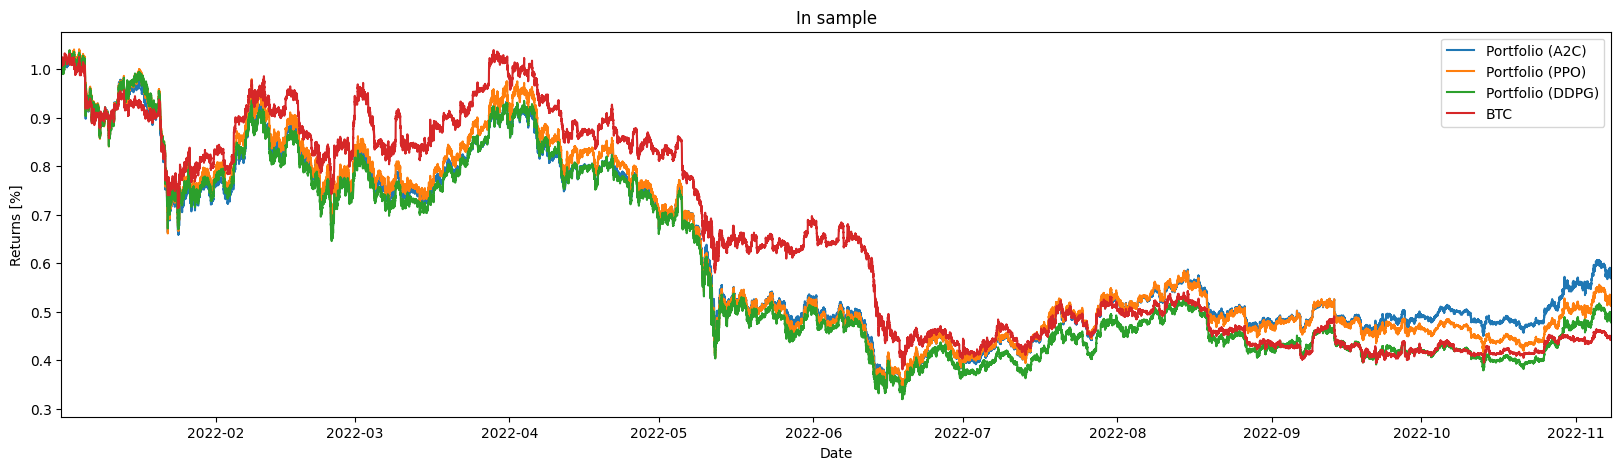

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(20, 5))

# Plot portfolio returns for each model
for model_name, rewards in total_rewards_train.items():
    ax.plot(df_close.open_time_ms[13:val_idx+13], [r/10000 for r in rewards], label=f'Portfolio ({model_name})')

# Plot BTC performance
ax.plot(df_close.open_time_ms[13:val_idx+13], df_close.BTC_close[13:val_idx+13] / df_close.BTC_close[0], label='BTC')

ax.set_xlim(df_close.open_time_ms[13], df_close.open_time_ms[val_idx+13])
ax.set_title('In sample')
ax.set_ylabel('Returns [%]')
ax.set_xlabel('Date')
ax.legend()

#### Validation Performance

In [ ]:
total_rewards_val = {}

# Predict performance for each model
for model_name, model in models.items():
    env_predict = CryptoPortfolioEnvV2(df=val_data, max_timesteps=val_data.shape[0], mode='predict')
    obs = env_predict.reset()
    
    for i in tqdm(range(val_data.shape[0]), desc=f'{model_name} prediction'):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env_predict.step(action)
    
    total_rewards_val[model_name] = env_predict.save_asset_memory()

A2C prediction:   0%|          | 0/19198 [00:00<?, ?it/s]

PPO prediction:   0%|          | 0/19198 [00:00<?, ?it/s]

DDPG prediction:   0%|          | 0/19198 [00:00<?, ?it/s]

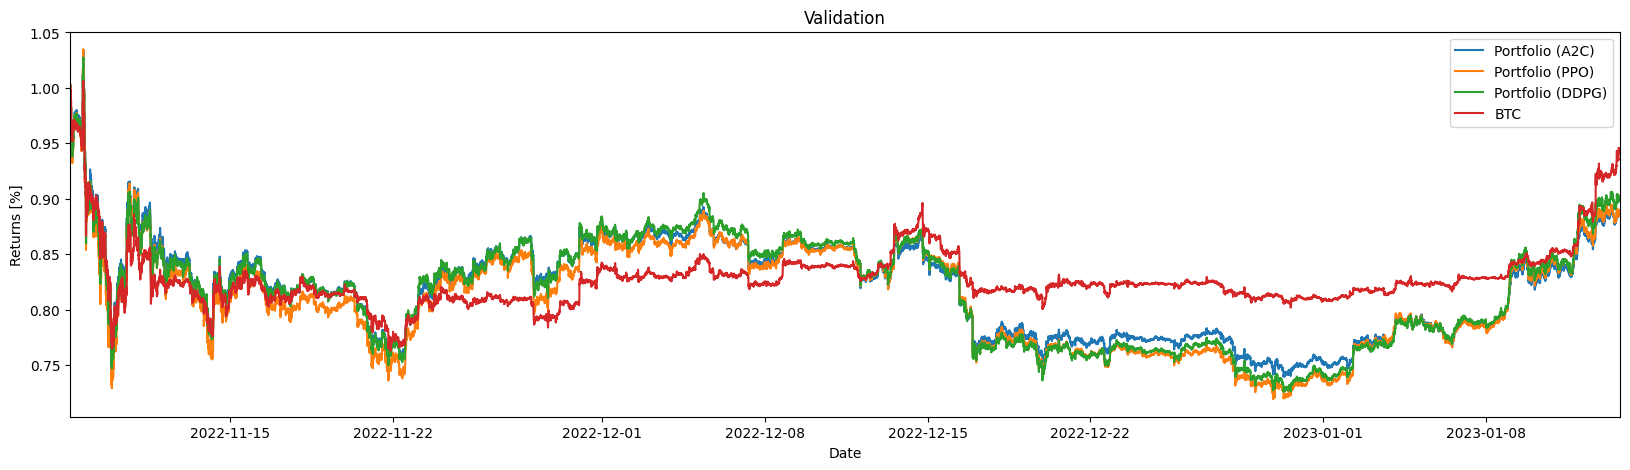

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(20, 5))

# Plot portfolio returns for each model
for model_name, rewards in total_rewards_val.items():
    ax.plot(df_close.open_time_ms[val_idx+13:test_idx+13], [r/10000 for r in rewards], label=f'Portfolio ({model_name})')

# Plot BTC performance
ax.plot(df_close.open_time_ms[val_idx+13:test_idx+13], df_close.BTC_close[val_idx+13:test_idx+13] / df_close.BTC_close[val_idx+13], label='BTC')

ax.set_xlim(df_close.open_time_ms[val_idx+13],df_close.open_time_ms[test_idx+12])
ax.set_title('Validation')
ax.set_ylabel('Returns [%]')
ax.set_xlabel('Date')
ax.legend()

### Env-V3

feed in with data2

In [ ]:
env_train = LongShortEnv(full_data = train_data2)

model_a2c_2 = A2C("MlpPolicy", env_train, verbose=0)
model_a2c_2.learn(total_timesteps=300000)
model_a2c_2.save("a2c_ls")

Episode: 0 | Timesteps: 10000 | Cumulative Return: -3.65%
Episode: 1 | Timesteps: 10000 | Cumulative Return: -5.53%
Episode: 2 | Timesteps: 10000 | Cumulative Return: 3.00%
Episode: 3 | Timesteps: 10000 | Cumulative Return: -2.12%
Episode: 4 | Timesteps: 10000 | Cumulative Return: 4.62%
Episode: 5 | Timesteps: 10000 | Cumulative Return: 11.31%
Episode: 6 | Timesteps: 10000 | Cumulative Return: 5.98%
Episode: 7 | Timesteps: 10000 | Cumulative Return: -1.45%
Episode: 8 | Timesteps: 10000 | Cumulative Return: -2.23%
Episode: 9 | Timesteps: 10000 | Cumulative Return: 6.26%
Episode: 10 | Timesteps: 10000 | Cumulative Return: 3.44%
Episode: 11 | Timesteps: 10000 | Cumulative Return: -10.96%
Episode: 12 | Timesteps: 10000 | Cumulative Return: 16.57%
Episode: 13 | Timesteps: 10000 | Cumulative Return: 3.66%
Episode: 14 | Timesteps: 10000 | Cumulative Return: 5.44%
Episode: 15 | Timesteps: 10000 | Cumulative Return: 7.11%
Episode: 16 | Timesteps: 10000 | Cumulative Return: 3.32%
Episode: 17 | T

In [ ]:
env_train = LongShortEnv(full_data = train_data2)

model_ppo_2 = PPO("MlpPolicy", env_train, verbose=0)
model_ppo_2.learn(total_timesteps=300000)
model_ppo_2.save("ppo_ls")

Episode: 0 | Timesteps: 10000 | Cumulative Return: -6.12%
Episode: 1 | Timesteps: 10000 | Cumulative Return: 5.22%
Episode: 2 | Timesteps: 10000 | Cumulative Return: -0.56%
Episode: 3 | Timesteps: 10000 | Cumulative Return: 9.00%
Episode: 4 | Timesteps: 10000 | Cumulative Return: -8.30%
Episode: 5 | Timesteps: 10000 | Cumulative Return: 2.23%
Episode: 6 | Timesteps: 10000 | Cumulative Return: 3.57%
Episode: 7 | Timesteps: 10000 | Cumulative Return: 10.24%
Episode: 8 | Timesteps: 10000 | Cumulative Return: -5.91%
Episode: 9 | Timesteps: 10000 | Cumulative Return: -6.03%
Episode: 10 | Timesteps: 10000 | Cumulative Return: -0.66%
Episode: 11 | Timesteps: 10000 | Cumulative Return: -6.14%
Episode: 12 | Timesteps: 10000 | Cumulative Return: 24.53%
Episode: 13 | Timesteps: 10000 | Cumulative Return: 4.09%
Episode: 14 | Timesteps: 10000 | Cumulative Return: 3.73%
Episode: 15 | Timesteps: 10000 | Cumulative Return: 0.15%
Episode: 16 | Timesteps: 10000 | Cumulative Return: -1.01%
Episode: 17 | 

In [ ]:
env_train = LongShortEnv(full_data = train_data2)

model_ddpg_2 = DDPG("MlpPolicy", env_train, verbose=0)
model_ddpg_2.learn(total_timesteps=300000)
model_ddpg_2.save("ddpg_ls")

Episode: 0 | Timesteps: 10000 | Cumulative Return: 2.32%
Episode: 1 | Timesteps: 10000 | Cumulative Return: 11.99%
Episode: 2 | Timesteps: 10000 | Cumulative Return: 0.26%
Episode: 3 | Timesteps: 10000 | Cumulative Return: 2.22%
Episode: 4 | Timesteps: 10000 | Cumulative Return: -4.67%
Episode: 5 | Timesteps: 10000 | Cumulative Return: -0.73%
Episode: 6 | Timesteps: 10000 | Cumulative Return: -0.28%
Episode: 7 | Timesteps: 10000 | Cumulative Return: -0.82%
Episode: 8 | Timesteps: 10000 | Cumulative Return: -3.30%
Episode: 9 | Timesteps: 10000 | Cumulative Return: 1.40%
Episode: 10 | Timesteps: 10000 | Cumulative Return: 2.59%
Episode: 11 | Timesteps: 10000 | Cumulative Return: -0.68%
Episode: 12 | Timesteps: 10000 | Cumulative Return: -0.05%
Episode: 13 | Timesteps: 10000 | Cumulative Return: -1.50%
Episode: 14 | Timesteps: 10000 | Cumulative Return: -0.69%
Episode: 15 | Timesteps: 10000 | Cumulative Return: 2.46%
Episode: 16 | Timesteps: 10000 | Cumulative Return: -1.20%
Episode: 17 |

#### Training Performance

In [ ]:
models = {
    "A2C": model_a2c_2,
    "PPO": model_ppo_2,
    "DDPG": model_ddpg_2
}

In [ ]:
rewards_log_train = {}
weights_log_train = {}

# Predict performance for each model
for model_name, model in models.items():
    env_predict = LongShortEnv(full_data=train_data2, total_time=train_data2.shape[0], mode='Val', rand_start_time=False)
    obs = env_predict.reset()
    
    for i in tqdm(range(train_data2.shape[0]), desc=f'{model_name} prediction'):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env_predict.step(action)
    
    rewards_log_train[model_name] = env_predict.save_asset_memory()
    weights_log_train[model_name] = env_predict.save_action_memory()

A2C prediction:   0%|          | 0/63987 [00:00<?, ?it/s]

Done


PPO prediction:   0%|          | 0/63987 [00:00<?, ?it/s]

Done


DDPG prediction:   0%|          | 0/63987 [00:00<?, ?it/s]

Done


In [ ]:
# add baseline
baseline_reward_train = [10000]

for t in range(1,val_idx):
  data_now = data2[t,:,:]
  data_prev = data2[t-1,:,:]
  portfolio_return = torch.sum(((data_now[:,0] / data_prev[:,0]) - 1) * torch.full((16,), 1/16))
  new_portfolio_value = baseline_reward_train[t-1] * (1 + portfolio_return)
  baseline_reward_train.append(new_portfolio_value.item())

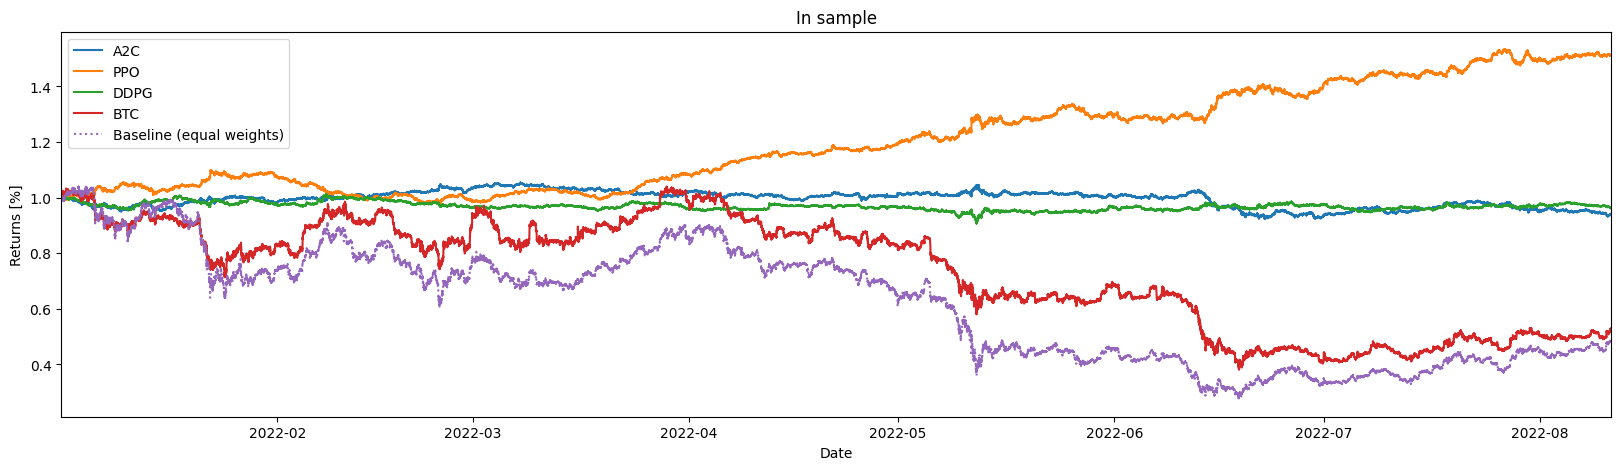

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(20, 5))

# Plot portfolio returns for each model
for model_name, rewards in rewards_log_train.items():
    ax.plot(df_close.open_time_ms[13:val_idx+13], [r/10000 for r in rewards], label=f'{model_name}')

# Plot BTC performance
ax.plot(df_close.open_time_ms[13:val_idx+13], df_close.BTC_close[13:val_idx+13] / df_close.BTC_close[0], label='BTC')

# Plot the baseline
ax.plot(df_close.open_time_ms[13:val_idx+13], [r/10000 for r in baseline_reward_train], label='Baseline (equal weights)', linestyle=':')

ax.set_xlim(df_close.open_time_ms[13], df_close.open_time_ms[val_idx+13])
ax.set_title('In sample')
ax.set_ylabel('Returns [%]')
ax.set_xlabel('Date')
ax.legend()

#### Validation Performance

In [ ]:
rewards_log_valid = {}
weights_log_valid = {}

# Predict performance for each model
for model_name, model in models.items():
    env_predict = LongShortEnv(full_data=val_data2, total_time=val_data2.shape[0], mode='Val', rand_start_time=False)
    obs = env_predict.reset()
    
    for i in tqdm(range(val_data2.shape[0]-1), desc=f'{model_name} prediction'):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env_predict.step(action)
    
    rewards_log_valid[model_name] = env_predict.save_asset_memory()
    weights_log_valid[model_name] = env_predict.save_action_memory()

A2C prediction:   0%|          | 0/31993 [00:00<?, ?it/s]

PPO prediction:   0%|          | 0/31993 [00:00<?, ?it/s]

DDPG prediction:   0%|          | 0/31993 [00:00<?, ?it/s]

In [ ]:
# add baseline
baseline_reward_valid = [10000]

for t in range(val_idx+1,test_idx):
  data_now = data2[t,:,:]
  data_prev = data2[t-1,:,:]
  portfolio_return = torch.sum(((data_now[:,0] / data_prev[:,0]) - 1) * torch.full((16,), 1/16))
  new_portfolio_value = baseline_reward_valid[t-val_idx-1] * (1 + portfolio_return)
  baseline_reward_valid.append(new_portfolio_value.item())

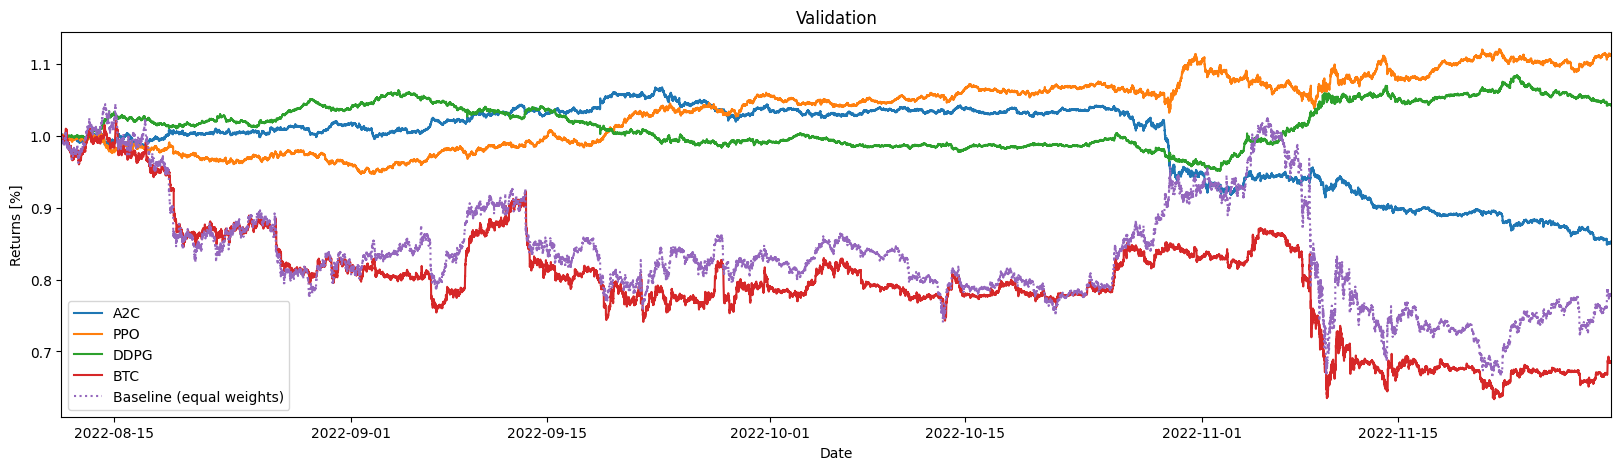

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(20, 5))

# Plot portfolio returns for each model
for model_name, rewards in rewards_log_valid.items():
    ax.plot(df_close.open_time_ms[val_idx+13:test_idx+13], [r/10000 for r in rewards], label=f'{model_name}')

# Plot BTC performance
ax.plot(df_close.open_time_ms[val_idx+13:test_idx+13], df_close.BTC_close[val_idx+13:test_idx+13] / df_close.BTC_close[val_idx+13], label='BTC')

# Plot the baseline
ax.plot(df_close.open_time_ms[val_idx+13:test_idx+13], [r/10000 for r in baseline_reward_valid], label='Baseline (equal weights)', linestyle=':')

ax.set_xlim(df_close.open_time_ms[val_idx+13],df_close.open_time_ms[test_idx+12])
ax.set_title('Validation')
ax.set_ylabel('Returns [%]')
ax.set_xlabel('Date')
ax.legend()

### Env-fine tune

fine tune for DDPG

In [ ]:
# hide all deprecation warnings from tensorflow
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

!pip install optuna
import optuna
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.9 MB/s eta 0:00:00


In [ ]:
#https://github.com/araffin/rl-baselines-zoo/issues/29

#https://stable-baselines3.readthedocs.io/en/master/modules/ddpg.html

def optimize_ddpg(trial):
    """ Learning hyperparamters we want to optimise"""
    return {
        'gamma': trial.suggest_loguniform('gamma', 0.01, 0.0999),
    }

def optimize_agent(trial):
    """ Train the model and optimize
        Optuna maximises the negative log likelihood, so we
        need to negate the reward here
    """
    model_params = optimize_ddpg(trial)
    env = make_vec_env(lambda: LongShortEnv(full_data = train_data2), n_envs=1, seed=0)
    model = DDPG('MlpPolicy', env, verbose=0, **model_params)
    model.learn(100)
    mean_reward, _ = evaluate_policy(model, LongShortEnv(full_data = train_data2), n_eval_episodes=10)

    return -1 * mean_reward


if __name__ == '__main__':
    study = optuna.create_study()
    try:
        study.optimize(optimize_agent, n_trials=10, n_jobs=4)
    except KeyboardInterrupt:
        print('Interrupted by keyboard.')

[I 2023-05-09 20:42:34,098] A new study created in memory with name: no-name-ce7b826b-c0fa-4f28-9a47-1d79470dadb5


Episode: 0 | Timesteps: 10000 | Cumulative Return: -1.79%
Episode: 0 | Timesteps: 10000 | Cumulative Return: 0.95%
Episode: 0 | Timesteps: 10000 | Cumulative Return: -1.98%
Episode: 0 | Timesteps: 10000 | Cumulative Return: -7.52%
Episode: 0 | Timesteps: 10000 | Cumulative Return: 0.80%
Episode: 0 | Timesteps: 10000 | Cumulative Return: 13.04%
Episode: 1 | Timesteps: 10000 | Cumulative Return: -5.39%
Episode: 1 | Timesteps: 10000 | Cumulative Return: -3.92%
Episode: 0 | Timesteps: 10000 | Cumulative Return: -14.32%
Episode: 2 | Timesteps: 10000 | Cumulative Return: 0.84%
Episode: 0 | Timesteps: 10000 | Cumulative Return: 0.46%
Episode: 0 | Timesteps: 10000 | Cumulative Return: -7.13%
Episode: 2 | Timesteps: 10000 | Cumulative Return: -5.46%
Episode: 0 | Timesteps: 10000 | Cumulative Return: 3.41%
Episode: 1 | Timesteps: 10000 | Cumulative Return: -1.15%
Episode: 3 | Timesteps: 10000 | Cumulative Return: -4.69%
Episode: 1 | Timesteps: 10000 | Cumulative Return: 3.93%
Episode: 1 | Timest

[I 2023-05-09 21:02:31,112] Trial 4 finished with value: 0.018042268513022465 and parameters: {'gamma': 0.9116636709100795}. Best is trial 0 with value: -0.013661720839036207.


Episode: 7 | Timesteps: 10000 | Cumulative Return: -1.33%
Episode: 7 | Timesteps: 10000 | Cumulative Return: -5.90%
Episode: 9 | Timesteps: 10000 | Cumulative Return: 3.16%


[I 2023-05-09 21:02:50,124] Trial 5 finished with value: -0.03360389335498439 and parameters: {'gamma': 0.937244823333635}. Best is trial 5 with value: -0.03360389335498439.


Episode: 7 | Timesteps: 10000 | Cumulative Return: -2.17%
Episode: 8 | Timesteps: 10000 | Cumulative Return: 1.01%
Episode: 8 | Timesteps: 10000 | Cumulative Return: -2.06%
Episode: 8 | Timesteps: 10000 | Cumulative Return: -0.15%
Episode: 8 | Timesteps: 10000 | Cumulative Return: 1.04%
Episode: 9 | Timesteps: 10000 | Cumulative Return: -10.98%


[I 2023-05-09 21:03:57,357] Trial 3 finished with value: 0.07090997632371909 and parameters: {'gamma': 0.030814049988248087}. Best is trial 3 with value: 0.07090997632371909.


Episode: 9 | Timesteps: 10000 | Cumulative Return: 3.22%


[I 2023-05-09 21:04:08,965] Trial 2 finished with value: -0.009226271824195465 and parameters: {'gamma': 0.04286185864723311}. Best is trial 2 with value: -0.009226271824195465.


Episode: 9 | Timesteps: 10000 | Cumulative Return: -2.60%


[I 2023-05-09 21:04:15,936] Trial 0 finished with value: 0.003960665429315213 and parameters: {'gamma': 0.015159033997033375}. Best is trial 2 with value: -0.009226271824195465.


Episode: 9 | Timesteps: 10000 | Cumulative Return: 2.72%


[I 2023-05-09 21:04:35,464] Trial 1 finished with value: -0.017458383845314528 and parameters: {'gamma': 0.02279845253608025}. Best is trial 1 with value: -0.017458383845314528.


Episode: 0 | Timesteps: 10000 | Cumulative Return: -10.78%
Episode: 0 | Timesteps: 10000 | Cumulative Return: 0.66%
Episode: 0 | Timesteps: 10000 | Cumulative Return: 4.86%
Episode: 0 | Timesteps: 10000 | Cumulative Return: 5.25%
Episode: 0 | Timesteps: 10000 | Cumulative Return: 1.01%
Episode: 0 | Timesteps: 10000 | Cumulative Return: -1.65%
Episode: 1 | Timesteps: 10000 | Cumulative Return: -6.45%
Episode: 0 | Timesteps: 10000 | Cumulative Return: -0.30%
Episode: 1 | Timesteps: 10000 | Cumulative Return: 1.96%
Episode: 0 | Timesteps: 10000 | Cumulative Return: -4.72%
Episode: 2 | Timesteps: 10000 | Cumulative Return: -0.47%
Episode: 1 | Timesteps: 10000 | Cumulative Return: -1.08%
Episode: 2 | Timesteps: 10000 | Cumulative Return: -4.64%
Episode: 1 | Timesteps: 10000 | Cumulative Return: 3.79%
Episode: 3 | Timesteps: 10000 | Cumulative Return: -6.01%
Episode: 2 | Timesteps: 10000 | Cumulative Return: 0.41%
Episode: 3 | Timesteps: 10000 | Cumulative Return: 1.05%
Episode: 2 | Timestep

[I 2023-05-09 21:16:03,732] Trial 4 finished with value: 0.025775215609928636 and parameters: {'gamma': 0.022698054648769228}. Best is trial 1 with value: -0.017458383845314528.


Episode: 8 | Timesteps: 10000 | Cumulative Return: -3.37%
Episode: 9 | Timesteps: 10000 | Cumulative Return: 1.66%


[I 2023-05-09 21:16:36,439] Trial 5 finished with value: 0.01227420512768731 and parameters: {'gamma': 0.013480769381114371}. Best is trial 1 with value: -0.017458383845314528.


Episode: 8 | Timesteps: 10000 | Cumulative Return: -0.76%
Episode: 0 | Timesteps: 10000 | Cumulative Return: -8.93%
Episode: 9 | Timesteps: 10000 | Cumulative Return: -2.71%


[I 2023-05-09 21:16:56,095] Trial 6 finished with value: 0.014852867987974605 and parameters: {'gamma': 0.07723944801848508}. Best is trial 1 with value: -0.017458383845314528.


Episode: 0 | Timesteps: 10000 | Cumulative Return: -4.07%


[I 2023-05-09 21:17:16,765] Trial 7 finished with value: 0.016748174420808937 and parameters: {'gamma': 0.011096098028192532}. Best is trial 1 with value: -0.017458383845314528.


Episode: 9 | Timesteps: 10000 | Cumulative Return: 4.28%
Episode: 0 | Timesteps: 10000 | Cumulative Return: 2.69%
Episode: 0 | Timesteps: 10000 | Cumulative Return: 6.08%
Episode: 1 | Timesteps: 10000 | Cumulative Return: 3.18%
Episode: 1 | Timesteps: 10000 | Cumulative Return: 3.83%
Episode: 2 | Timesteps: 10000 | Cumulative Return: 6.11%
Episode: 2 | Timesteps: 10000 | Cumulative Return: -7.93%
Episode: 3 | Timesteps: 10000 | Cumulative Return: -0.80%
Episode: 3 | Timesteps: 10000 | Cumulative Return: 4.10%
Episode: 4 | Timesteps: 10000 | Cumulative Return: 8.69%
Episode: 4 | Timesteps: 10000 | Cumulative Return: 3.74%
Episode: 5 | Timesteps: 10000 | Cumulative Return: -2.88%
Episode: 5 | Timesteps: 10000 | Cumulative Return: 3.90%
Episode: 6 | Timesteps: 10000 | Cumulative Return: 6.65%
Episode: 6 | Timesteps: 10000 | Cumulative Return: -1.88%
Episode: 7 | Timesteps: 10000 | Cumulative Return: -0.48%
Episode: 7 | Timesteps: 10000 | Cumulative Return: 1.18%
Episode: 8 | Timesteps: 10

[I 2023-05-09 21:21:28,377] Trial 8 finished with value: -0.023726812366498963 and parameters: {'gamma': 0.059301327683622784}. Best is trial 8 with value: -0.023726812366498963.


Episode: 9 | Timesteps: 10000 | Cumulative Return: 0.38%


[I 2023-05-09 21:21:36,205] Trial 9 finished with value: -0.013098280689928288 and parameters: {'gamma': 0.02102221038814909}. Best is trial 8 with value: -0.023726812366498963.


Episode: 9 | Timesteps: 10000 | Cumulative Return: -4.02%
